In [1]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
from arch import arch_model 
import matplotlib.pyplot as plt 
from numba import jit
from sklearn.metrics import mean_squared_error as mse 
import warnings
warnings.filterwarnings('ignore')

In [2]:
stocks='^GSPC'
start=datetime.datetime(2010,1,1)
end=datetime.datetime(2021,8,1)
s_p500=yf.download(stocks, start=start, end=end, interval='1d')

[*********************100%***********************]  1 of 1 completed


In [3]:
ret=100*(s_p500.pct_change()[1:]['Adj Close'])
realized_vol=ret.rolling(5).std()

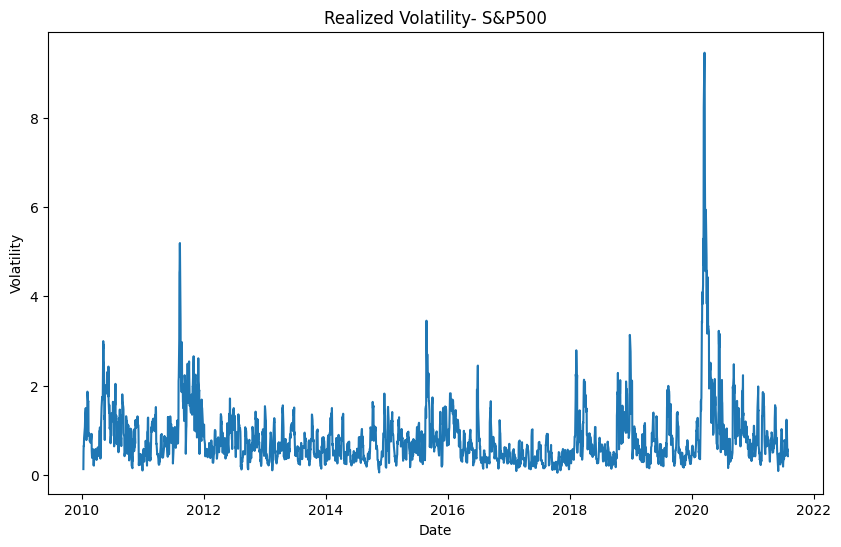

In [4]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol.index, realized_vol)
plt.title('Realized Volatility- S&P500')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

In [5]:
retv=ret.values

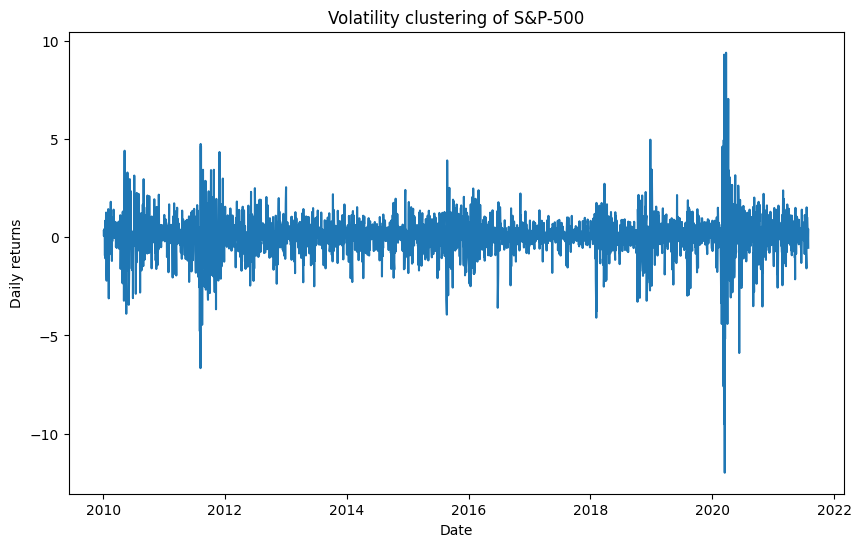

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(s_p500.index[1:], ret)
plt.title('Volatility clustering of S&P-500')
plt.ylabel('Daily returns')
plt.xlabel('Date')
plt.show()